In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import regex
import scipy.stats as stats
import scipy.optimize as optimize
import scipy.signal as signal
from scipy import cluster
from Bio import SeqIO
from Bio.Seq import Seq, MutableSeq 
from Bio.SeqUtils import GC  
import random
from SCvariables import *
%matplotlib inline

sns.set_style('white')
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

In [2]:
genome_folder = './data/scer/'
genomefasta = {}
for i in range(1,10):
    x = loading_fasta_gbk(genome_folder + 'chr0{}.fsa'.format(i),'fasta')
    genomefasta[x.name] = x
for i in range(10,17):
    x = loading_fasta_gbk(genome_folder + 'chr{}.fsa'.format(i),'fasta')
    genomefasta[x.name] = x

chr_lengths = pd.read_csv(genome_folder + 'scer.genome',sep = '\t',header=None)
chr_lengths.columns = ['chromosome','length']

yeastgenome = {}
chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']
for i in range(1,10):
    x = loading_fasta_gbk(genome_folder + 'chr0{}.gb'.format(i),'genbank')
    yeastgenome['chr'+chroms[i-1]] = reading_gbk_new(x,['CDS','tRNA','rRNA','ncRNA'])
for i in range(10,17):
    x = loading_fasta_gbk(genome_folder + 'chr{}.gb'.format(i),'genbank')
    yeastgenome['chr'+chroms[i-1]] = reading_gbk_new(x,['CDS','tRNA','rRNA','ncRNA'])


##yeastgenome representation puts a 1 where there is a gene
yeastgenome_gene_representation = {}
for key, val in iter(yeastgenome.items()):
    x = np.zeros([1,len(genomefasta[key].seq)])
    for genes in [val]:
        for i in range (0, len(genes.annotation)):
            if genes.strand[i]== +1:
                for j in range(0, genes.length[i]-1):
                    x[0][genes.start[i]+j]=10
            else:
                for j in range(0,genes.length[i]-1):
                    x[0][genes.end[i]+j]=-10
    yeastgenome_gene_representation[key] = x
    
#convert into a pandas...
genomedict = {}
chroms = ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']
for c in chroms:
    chrom = 'chr'+c
    name,start,end,strand=[],[],[],[]
    for j in range(len(yeastgenome[chrom].start)):
        name.append(yeastgenome[chrom].name[j])
        start.append(yeastgenome[chrom].start[j])
        end.append(yeastgenome[chrom].end[j])
        strand.append(yeastgenome[chrom].strand[j])
    genomedict[chrom] = pd.DataFrame([name,start,end,strand],['name','start','end','strand']).transpose()
    
#calculate AT content
sliding_100 = {}
for key, val in iter(genomefasta.items()):
    sliding_100[key] = sliding_window(val,100)[0]
    
genomedict = formatGenomeDict(genomedict,genomefasta)

In [3]:
RNAseq = loadyeastRNAseqData() #raff data
RNAseq_RPKM = pd.read_csv('./data/RNAseq_rpkm_merged.txt',sep=',')

downloading GSM5001907_D20-252008_nodup_plus_all.txt.gz from GEO
unzipping GSM5001907_D20-252008_nodup_plus_all.txt.gz


/home/msguo/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


downloading GSM5001907_D20-252008_nodup_minus_all.txt.gz from GEO
unzipping GSM5001907_D20-252008_nodup_minus_all.txt.gz


In [4]:
GapR_raff = loadraffChIP()
GapR_raffneg = loadraffnegChIP()
chip_fold = loadChIPFold(GapR_raff, GapR_raffneg)

downloading GSM5001899_D20-5952_all_nodup.txt.gz from GEO
unzipping GSM5001899_D20-5952_all_nodup.txt.gz
downloading GSM5001905_D20-261001_all_nodup.txt.gz from GEO
unzipping GSM5001905_D20-261001_all_nodup.txt.gz


### Fig. 4A

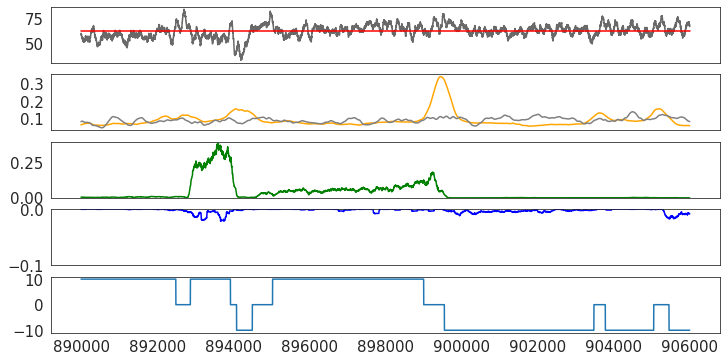

In [5]:
start = 890000
end = 906000
chrom = 'chrIV'
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12,6), sharey=False)
axes[0].plot(np.arange(start, end),sliding_100[chrom][start:end],'dimgrey')
axes[0].plot([start, end],[np.mean(sliding_100[chrom]),np.mean(sliding_100[chrom])], 'red')
axes[1].plot(np.arange(start, end),GapR_raff[GapR_raff.chr==chrom].smooth[start:end], 'orange')
axes[1].plot(np.arange(start, end),GapR_raffneg[GapR_raffneg.chr==chrom].smooth[start:end], 'grey')

axes[2].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].fwd[start:end]),'green')
axes[3].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].rev[start:end]),'blue')

axes[2].set_ylim([0,0.4])
axes[3].set_ylim([-0.1,0])

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)

axes[4].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

### Fig. 4B

In [6]:
la = {}
for chrom in genomedict.keys():
    la[chrom] = chip_fold[chip_fold.chr==chrom].iloc[0].name
N=500
RNAseq_new = RNAseq_RPKM.copy()
for c in ['I','II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']:
    chrom = 'chr'+c
    l = len(genomefasta[chrom].seq)
    e = RNAseq_RPKM[RNAseq_RPKM.chr == chrom].iloc[-1]
    if (l - np.max([e.end,e.start])) < N:
        RNAseq_new.drop(index = e.name,inplace=True)
    e = RNAseq_RPKM[RNAseq_RPKM.chr == chrom].iloc[0]
    if (np.min([e.fullend,e.fullstart]) - la[chrom]) < N:
        RNAseq_new.drop(index = e.name,inplace=True)

In [7]:
N = 500
geneL = 1000
plus = RNAseq_new[(RNAseq_new.strand == 1) & (abs(RNAseq_new.end-RNAseq_new.start) >= geneL)]
minus = RNAseq_new[(RNAseq_new.strand == -1) & (abs(RNAseq_new.end-RNAseq_new.start) >= geneL)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.fullend >= values.fullend) & (minus.fullend <= values.fullend+N)])
    if len(x) != 0:
        t.append(x)

minus_new = minus.copy()
for x in t:
    try:
        minus_new.drop(index = x.index,inplace=True)
    except:
        pass

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.fullstart) & (plus.start <= values.fullstart+N)])
    if len(x) != 0:
        t2.append(x)
        
plus_new = plus.copy()
for x in t2:
    try:
        plus_new.drop(index = x.index,inplace=True)
    except:
        pass

len(minus), len(minus_new), len(plus), len(plus_new)

(1756, 1275, 1837, 1665)

In [8]:
threepr_gapR_mean = []
fivepr_gapR_mean = []

for index,values in plus.iterrows():
    end = int(values.fullend)
    threepr_gapR_mean.append(np.mean(chip_fold.fold_nolog[end:end+N].values))
    
for index,values in minus_new.iterrows():
    end = int(values.fullend)
    threepr_gapR_mean.append(np.mean(chip_fold.fold_nolog[end-N:end].values))

for index,values in plus_new.iterrows():
    start = int(values.fullstart)
    fivepr_gapR_mean.append(np.mean(chip_fold.fold_nolog[start-N:start].values))
    
for index,values in minus.iterrows():
    start = int(values.fullstart)
    fivepr_gapR_mean.append(np.mean(chip_fold.fold_nolog[start:start+N].values))

Ttest_indResult(statistic=-18.755164473535878, pvalue=1.7460403009465667e-76)

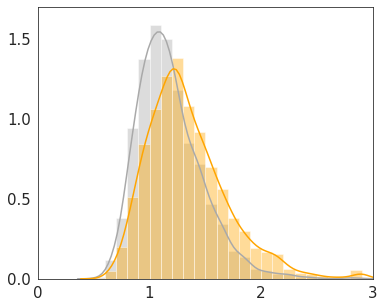

In [9]:
plt.figure(figsize=[6,5])
bins = np.arange(0,3,0.1)
sns.distplot(np.clip(fivepr_gapR_mean,bins[0],bins[-1]),bins=bins,color='darkgrey')
sns.distplot(np.clip(threepr_gapR_mean,bins[0],bins[-1]),bins=bins,color='orange')
plt.xticks([0,1,2,3])
plt.yticks([0,0.5,1.0,1.5])

plt.ylim([0,1.7])
plt.xlim([0,3])

stats.ttest_ind(fivepr_gapR_mean, threepr_gapR_mean)

### Fig. 4C

In [10]:
N = 500
geneL = 1000
plus = RNAseq_new[(RNAseq_new.strand == 1) & (abs(RNAseq_new.end-RNAseq_new.start) >= geneL)]
minus = RNAseq_new[(RNAseq_new.strand == -1) & (abs(RNAseq_new.end-RNAseq_new.start) >= geneL)]

t = []
for index, values in plus.iterrows():
    x = (minus[(minus.fullend >= values.fullend) & (minus.fullend <= values.fullend+N)])
    if len(x) != 0:
        t.append(x)

minus_new = minus.copy()
for x in t:
    try:
        minus_new.drop(index = x.index,inplace=True)
    except:
        pass

t2 = []
for index, values in minus.iterrows():
    x = (plus[(plus.start >= values.fullstart) & (plus.start <= values.fullstart+N)])
    if len(x) != 0:
        t2.append(x)
        
plus_new = plus.copy()
for x in t2:
    try:
        plus_new.drop(index = x.index,inplace=True)
    except:
        pass

len(minus), len(minus_new), len(plus), len(plus_new)

(1756, 1275, 1837, 1665)

In [11]:
#find bottom 500
print(len(plus)+len(minus_new))
bot = 9.385
mid = 110
high = 225.3
vhigh = 455

print((len(plus[plus.gal < bot])+len(minus_new[minus_new.gal < bot])))
#top 500
print(len(plus[plus.gal > mid])+len(minus_new[minus_new.gal > mid]))
#top 250
print(len(plus[plus.gal > high])+len(minus_new[minus_new.gal > high]))
#top 125
print(len(plus[plus.gal > vhigh])+len(minus_new[minus_new.gal > vhigh]))

3112
500
500
250
125


In [12]:
pref_bot = []
pref_top = []
pref_top_A = []
pref_top_B = []
pref_top_C = []

for index,values in plus.iterrows():
    end = int(values.fullend)
    if values.gal < bot:
        pref_bot.append(np.mean(chip_fold.fold_nolog[end:end+N].values))#-chip_fold.fold_nolog[end-N:end].values))
    if values.gal >= bot:
        pref_top.append(np.mean(chip_fold.fold_nolog[end:end+N].values))#-chip_fold.fold_nolog[end-N:end].values))
    if values.gal > mid:
        pref_top_A.append(np.mean(chip_fold.fold_nolog[end:end+N].values))#-chip_fold.fold_nolog[end-N:end].values))
    if values.gal >= high:
        pref_top_B.append(np.mean(chip_fold.fold_nolog[end:end+N].values))#-chip_fold.fold_nolog[end-N:end].values))
    if values.gal >= vhigh:
        pref_top_C.append(np.mean(chip_fold.fold_nolog[end:end+N].values))#-chip_fold.fold_nolog[end-N:end].values))
        
for index,values in minus_new.iterrows():
    end = int(values.fullend)
    if values.gal < bot:
        pref_bot.append(np.mean(chip_fold.fold_nolog[end-N:end].values))#-chip_fold.fold_nolog[end:end+N].values))
    if values.gal >= bot:
        pref_top.append(np.mean(chip_fold.fold_nolog[end-N:end].values))#-chip_fold.fold_nolog[end:end+N].values))
    if values.gal > mid:
        pref_top_A.append(np.mean(chip_fold.fold_nolog[end-N:end].values))#-chip_fold.fold_nolog[end:end+N].values))
    if values.gal >= high:
        pref_top_B.append(np.mean(chip_fold.fold_nolog[end-N:end].values))#-chip_fold.fold_nolog[end:end+N].values))
    if values.gal >= vhigh:
        pref_top_C.append(np.mean(chip_fold.fold_nolog[end-N:end].values))#-chip_fold.fold_nolog[end:end+N].values))

Ttest_indResult(statistic=-10.796975323377703, pvalue=1.0519040233799608e-26)
Ttest_indResult(statistic=-14.587451110093722, pvalue=7.797165375511979e-44)
Ttest_indResult(statistic=-14.808902428915443, pvalue=1.0564765095508874e-43)
Ttest_indResult(statistic=-15.688267226250304, pvalue=5.447068336618741e-47)


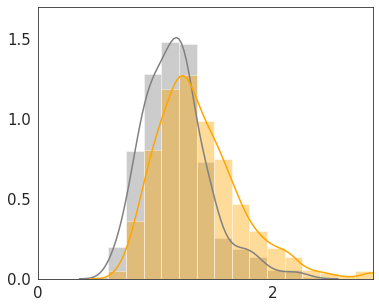

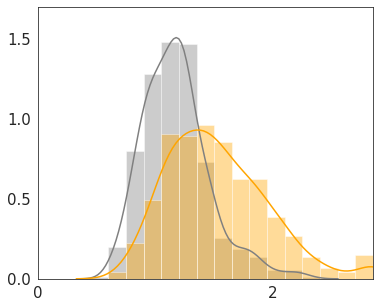

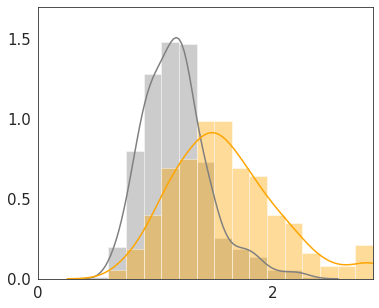

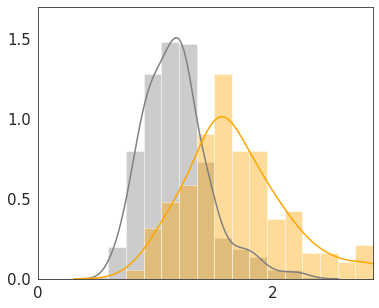

In [13]:
#Fig. 4C transcription dependence:
plt.figure(figsize=[6,5])
bins = np.arange(0,3,0.15)
sns.distplot(np.clip(pref_bot,bins[0],bins[-1]), bins=bins,color='grey')
sns.distplot(np.clip(pref_top,bins[0],bins[-1]), bins=bins,color='orange')

plt.xticks([0,2,4],size = 15)
plt.yticks([0,0.5,1.0,1.5,2],size = 15)

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,1.7])

print(stats.ttest_ind(pref_bot,pref_top))

plt.figure(figsize=[6,5])
sns.distplot(np.clip(pref_bot,bins[0],bins[-1]), bins=bins,color='grey')
sns.distplot(np.clip(pref_top_A,bins[0],bins[-1]), bins=bins,color='orange')

plt.xticks([0,2,4],size = 15)
plt.yticks([0,0.5,1.0,1.5,2],size = 15)

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,1.7])

print(stats.ttest_ind(pref_bot,pref_top_A))

plt.figure(figsize=[6,5])
sns.distplot(np.clip(pref_bot,bins[0],bins[-1]), bins=bins,color='grey')
sns.distplot(np.clip(pref_top_B,bins[0],bins[-1]), bins=bins,color='orange')

plt.xticks([0,2,4],size = 15)
plt.yticks([0,0.5,1.0,1.5,2],size = 15)

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,1.7])

print(stats.ttest_ind(pref_bot,pref_top_B))

plt.figure(figsize=[6,5])
sns.distplot(np.clip(pref_bot,bins[0],bins[-1]), bins=bins,color='grey')
sns.distplot(np.clip(pref_top_C,bins[0],bins[-1]), bins=bins,color='orange')

plt.xticks([0,2,4],size = 15)
plt.yticks([0,0.5,1.0,1.5,2],size = 15)

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,1.7])

print(stats.ttest_ind(pref_bot,pref_top_C))

In [14]:
#do it again, but w/ 5'
pref5_bot = []
pref5_top = []
pref5_top_A = []
pref5_top_B = []
pref5_top_C = []

for index,values in plus_new.iterrows():
    start = int(values.fullstart)
    if values.gal < bot:
        pref5_bot.append(np.mean(chip_fold.fold_nolog[start-N:start].values))
    if values.gal >= bot:
        pref5_top.append(np.mean(chip_fold.fold_nolog[start-N:start].values))
    if values.gal > mid:
        pref5_top_A.append(np.mean(chip_fold.fold_nolog[start-N:start].values))
    if values.gal >= high:
        pref5_top_B.append(np.mean(chip_fold.fold_nolog[start-N:start].values))
    if values.gal >= vhigh:
        pref5_top_C.append(np.mean(chip_fold.fold_nolog[start-N:start].values))
    
for index,values in minus.iterrows():
    start = int(values.fullstart)
    if values.gal < bot:
        pref5_bot.append(np.mean(chip_fold.fold_nolog[start:start+N].values))
    if values.gal >= bot:
        pref5_top.append(np.mean(chip_fold.fold_nolog[start:start+N].values))
    if values.gal > mid:
        pref5_top_A.append(np.mean(chip_fold.fold_nolog[start:start+N].values))
    if values.gal >= high:
        pref5_top_B.append(np.mean(chip_fold.fold_nolog[start:start+N].values))
    if values.gal >= vhigh:
        pref5_top_C.append(np.mean(chip_fold.fold_nolog[start:start+N].values))

Ttest_indResult(statistic=-2.159486711929229, pvalue=0.030881751207989666)
Ttest_indResult(statistic=-3.0121070363026727, pvalue=0.0026558393257042627)
Ttest_indResult(statistic=-1.29233329814427, pvalue=0.19661771969289016)
Ttest_indResult(statistic=0.6879809906309184, pvalue=0.4917061030413713)


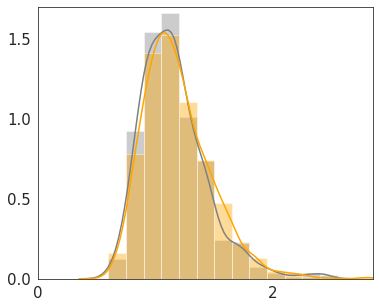

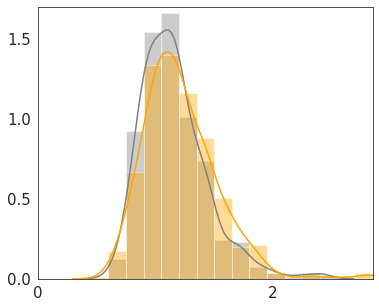

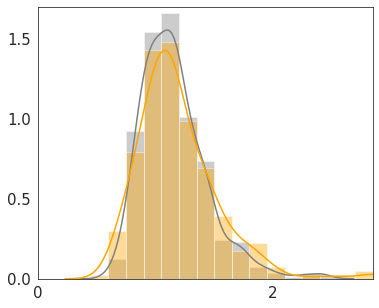

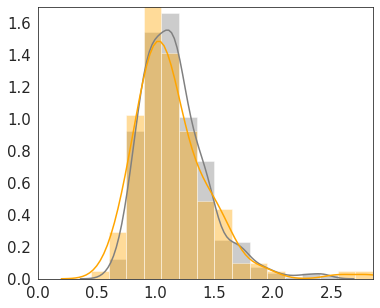

In [15]:
#Fig. 4C transcription dependence:
plt.figure(figsize=[6,5])
bins = np.arange(0,3,0.15)
sns.distplot(np.clip(pref5_bot,bins[0],bins[-1]), bins=bins,color='grey')
sns.distplot(np.clip(pref5_top,bins[0],bins[-1]), bins=bins,color='orange')

plt.xticks([0,2,4],size = 15)
plt.yticks([0,0.5,1.0,1.5,2],size = 15)

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,1.7])

print(stats.ttest_ind(pref5_bot,pref5_top))

plt.figure(figsize=[6,5])
sns.distplot(np.clip(pref5_bot,bins[0],bins[-1]), bins=bins,color='grey')
sns.distplot(np.clip(pref5_top_A,bins[0],bins[-1]), bins=bins,color='orange')

plt.xticks([0,2,4],size = 15)
plt.yticks([0,0.5,1.0,1.5,2],size = 15)

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,1.7])

print(stats.ttest_ind(pref5_bot,pref5_top_A))

plt.figure(figsize=[6,5])
sns.distplot(np.clip(pref5_bot,bins[0],bins[-1]), bins=bins,color='grey')
sns.distplot(np.clip(pref5_top_B,bins[0],bins[-1]), bins=bins,color='orange')

plt.xticks([0,2,4],size = 15)
plt.yticks([0,0.5,1.0,1.5,2],size = 15)

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,1.7])

print(stats.ttest_ind(pref5_bot,pref5_top_B))

plt.figure(figsize=[6,5])
sns.distplot(np.clip(pref5_bot,bins[0],bins[-1]), bins=bins,color='grey')
sns.distplot(np.clip(pref5_top_C,bins[0],bins[-1]), bins=bins,color='orange')

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,1.7])

print(stats.ttest_ind(pref5_bot,pref5_top_C))

### Fig. 4D

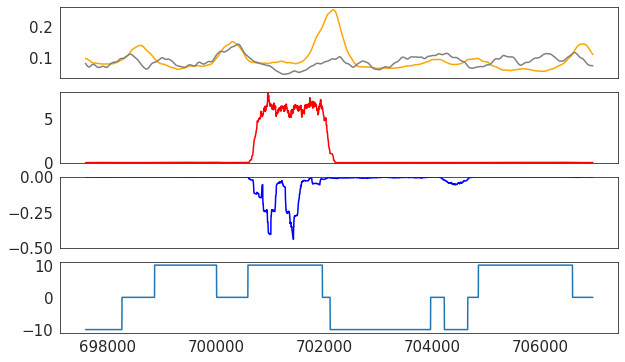

In [16]:
current = RNAseq_RPKM.iloc[6243]
chrom = current.chr
start=np.min([current.start, current.end])-3000
end=np.max([current.start, current.end])+5000
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),GapR_raff[GapR_raff.chr==chrom].smooth[start:end], 'orange')
axes[0].plot(np.arange(start, end),GapR_raffneg[GapR_raffneg.chr==chrom].smooth[start:end], 'grey')

axes[1].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].iloc[start:end].fwd),'red')
axes[2].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].iloc[start:end].rev),'blue')
axes[1].set_ylim([0,8])
axes[2].set_ylim([-0.5,0])
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

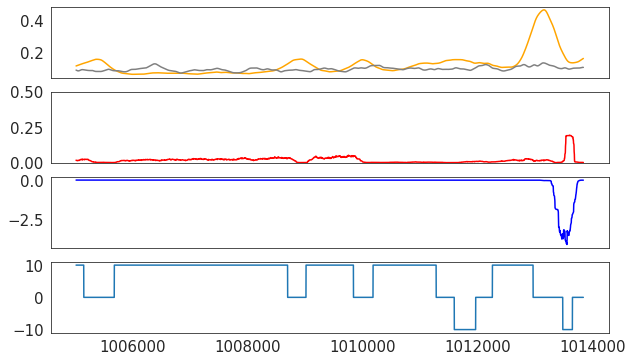

In [17]:
current = RNAseq_RPKM.iloc[1238]
chrom = current.chr
start=np.min([current.start, current.end])-4000
end=np.max([current.start, current.end])+4000
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,6), sharey=False)
#axes[0].plot(np.arange(start, end),chip_fold[chip_fold.chr==chrom].iloc[start:end].fold_nolog,'orange')
axes[0].plot(np.arange(start, end),GapR_raff[GapR_raff.chr==chrom].smooth[start:end], 'orange')
axes[0].plot(np.arange(start, end),GapR_raffneg[GapR_raffneg.chr==chrom].smooth[start:end], 'grey')

axes[1].plot(np.arange(start, end),(RNAseq[RNAseq.chr==chrom].iloc[start:end].fwd),'red')
axes[2].plot(np.arange(start, end),-(RNAseq[RNAseq.chr==chrom].iloc[start:end].rev),'blue')
axes[1].set_ylim([0,0.5])
#axes[2].set_ylim([-0.5,0])
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)

axes[3].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

### Fig. 4E

In [18]:
RNAseq_RPKM['real_start']=RNAseq_RPKM[['fullstart','fullend']].min(axis=1)
RNAseq_RPKM['real_end']=RNAseq_RPKM[['fullstart','fullend']].max(axis=1)
RNAseq_RPKM['geneL'] = RNAseq_RPKM.apply(lambda r:r['real_end']-r['real_start'],axis=1)
high_exp = RNAseq_RPKM[['name','strand','chr','real_start','real_end','geneL','gal']]
high_exp['intragenic_mean_gapR'] = high_exp.apply(lambda r:chip_fold.fold_nolog.loc[r['real_start']:r['real_end']].mean(),axis=1)
high_exp_final = high_exp

df_regions = pd.concat([high_exp_final,high_exp_final.shift(-1)],axis=1,keys=['left','right'],names=['gene'])
df_regions.columns = ['{}_{}'.format(x,y) for x,y in df_regions.columns]
df_regions = df_regions.dropna(subset=['right_real_start'])
df_regions=df_regions.loc[df_regions['left_chr']==df_regions['right_chr']]
df_regions.loc[df_regions['left_strand']==df_regions['right_strand'],'intergenic_type']='same'
df_regions.loc[(df_regions['left_strand']==1) & (df_regions['right_strand']==-1),'intergenic_type']='conv'
df_regions.loc[(df_regions['left_strand']==-1) & (df_regions['right_strand']==1),'intergenic_type']='div'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [19]:
df_regions['intergenic_mean_gapR']=df_regions.apply(lambda r:chip_fold.fold_nolog.loc[r['left_real_end']:r['right_real_start']].mean(),axis=1)
df_regions['intergenic_length']=df_regions.apply(lambda r:r['right_real_start']-r['left_real_end'],axis=1)
df_final = df_regions[df_regions.intergenic_length >50] #filter out things that are within X bases

conv 1561 Ttest_indResult(statistic=0.0, pvalue=1.0)
div 1604 Ttest_indResult(statistic=25.52790154011507, pvalue=7.360334738523992e-131)
same 2971 Ttest_indResult(statistic=16.053420155808098, pvalue=1.9015182493243005e-56)
intra 6377 Ttest_indResult(statistic=45.7517848962093, pvalue=0.0)


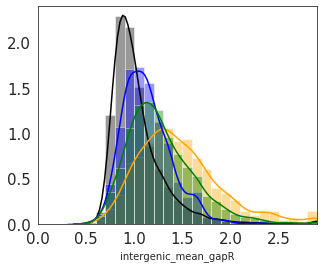

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
bins = np.arange(0,3,0.1)
sns.distplot(high_exp_final['intragenic_mean_gapR'].clip(bins[0],bins[-1]),bins=bins,color='black')

colors={'same':'green','div':'blue','conv':'orange'}
for i,g in df_final.groupby('intergenic_type'):
    sns.distplot(g['intergenic_mean_gapR'].clip(bins[0],bins[-1]),bins=bins,color=colors[i],label=i)
    print(i,len(g),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_gapR,g.intergenic_mean_gapR))

plt.xlim([bins[0],bins[-1]])
plt.ylim([0,2.4])

print('intra',len(high_exp_final),stats.ttest_ind(df_final[df_final.intergenic_type == 'conv'].intergenic_mean_gapR,high_exp_final.intragenic_mean_gapR))

### Fig. 4F

In [21]:
top5pct = enrichedRegions(chip_fold.fold_nolog,1.65722) #top 5 pct of positions len(chip_fold[chip_fold.fold_nolog > 2.38255])/len(chip_fold)

chip_diff = chip_fold.fold_nolog
out = []
regions = top5pct
m = np.mean(chip_diff)
s = np.std(chip_diff)
for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-15000:z[1]+15000]
    c_diff = c[c>(m+1/3*s)] #this is mean + 1/3 std
    j = z[1]
    while j < z[1]+15000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+15000
    j = z[0]
    while j > z[0]-15000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-15000
    if start > end:
        print('problem!')
    out.append(tuple([start,end]))
#merge GapR ChIPs
regions = sorted(list(set(out)))

out = []
i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 150: #merge within 150 bp
        end = regions[i][1]
        i += 1
    else:
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
GapR_peaks = out

#check if any GapR_peaks are close to chr ends, exclude them
lengths = []
for i in la.items():
    lengths.append(i[1])
    
GapR_checked = []
for i in GapR_peaks:
    start = np.min(i)
    end = np.max(i)
    append = True
    if start - 1000 <= 0:
        append=False
    else:
        for j in lengths:
            if abs(start - j) <= 1000:
                append=False
            if abs(end - j) <= 1000:
                append=False
                print(i)
    if append == True:
        GapR_checked.append(i)        

[1039506, 1042449]
[1042700, 1044341]
[1357880, 1359064]
[1359513, 1360775]
[6577926, 6578748]
[10031233, 10032568]


In [22]:
bot5pct = unenrichedRegions(chip_fold.fold_nolog,0.626158) #bottom 5 pct of positions len(chip_fold[chip_fold.fold_nolog < 0.3854025])/len(chip_fold)#0.04999765560138132

out = []
regions = bot5pct
for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-15000:z[1]+15000]
    c_diff = c[c>(m-1/3*s)] #this is mean - 1/3 std
    j = z[1]
    while j < z[1]+15000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+15000
    j = z[0]
    while j > z[0]-15000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-15000
    if start > end:
        print('problem!')
    out.append(tuple([start,end]))
#merge GapR ChIPs
regions = sorted(list(set(out)))

out = []
i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 150: #not sure if I should make longer
        end = regions[i][1]
        i += 1
    else:
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
outu_compress = out

#check if any GapR_peaks are close to chr ends, exclude them
outu_checked = []
for i in outu_compress:
    start = np.min(i)
    end = np.max(i)
    append = True
    if start - 1000 <= 0:
        append=False
    else:
        for j in lengths:
            if abs(start - j) <= 1000:
                append=False
            if abs(end - j) <= 1000:
                append=False
#                print(i)
    if append == True:
        outu_checked.append(i)    

In [23]:
n = 0.015 #cutoff for txn, np.mean(RNAseq.iloc[1628942:1629998].merged) #my cutoff for bottom 1000 is 0.0055 avg reads/base; the 0.015 cut off is a gene ~15 rpkM
direction = []
for i in GapR_checked:
    mid = int(round(np.mean(i),0))
    txn_avg = np.mean(RNAseq.iloc[mid-1000:mid+1000].merged)
    if txn_avg < n: 
        direction.append('no transcription')
    if txn_avg >= n:
        left_f = np.mean(RNAseq.iloc[mid-1000:mid].fwd)
        left_r = np.mean(RNAseq.iloc[mid-1000:mid].rev)        
        right_f = np.mean(RNAseq.iloc[mid:mid+1000].fwd)
        right_r = np.mean(RNAseq.iloc[mid:mid+1000].rev)        
            
        if ((left_f < n) and (left_r < n)) or ((right_f < n) and (right_r < n)):
            direction.append('same direction')
        elif left_f > left_r:
            if right_r > right_f:
                direction.append('convergent')
            else:
                direction.append('same direction')
        elif left_f <= left_r:
            if right_r > right_f:
                direction.append('same direction')
            else:
                direction.append('divergent')

In [24]:
#unenriched regions, compress regions 200 bp away
direction_u = []
for i in outu_checked:
    mid = int(round(np.mean(i),0))
    txn_avg = np.mean(RNAseq.iloc[mid-1000:mid+1000].merged)
    if txn_avg < n:
        direction_u.append('no transcription')
    if txn_avg >= n:
        left_f = np.mean(RNAseq.iloc[mid-1000:mid].fwd)
        left_r = np.mean(RNAseq.iloc[mid-1000:mid].rev)        
        right_f = np.mean(RNAseq.iloc[mid:mid+1000].fwd)
        right_r = np.mean(RNAseq.iloc[mid:mid+1000].rev)        
            
        if ((left_f < n) and (left_r < n)) or ((right_f < n) and (right_r < n)):
            direction_u.append('same direction')
        elif left_f > left_r:
            if right_r > right_f:
                direction_u.append('convergent')
            else:
                direction_u.append('same direction')
        elif left_f <= left_r:
            if right_r > right_f:
                direction_u.append('same direction')
            else:
                direction_u.append('divergent')    

In [25]:
#intergenic
direction_int = []
for chrom in genomedict.keys():
    for i in np.arange(1,len(genomedict[chrom])):
        last = genomedict[chrom].loc[i-1]
        current = genomedict[chrom].loc[i]    
        start = int(max([last.fullend,last.fullstart]))
        end = int(min(current.fullend,current.fullstart))
        
        mid = int(round(np.mean([start,end]),0))
        txn_avg = np.mean(RNAseq.iloc[mid-1000:mid+1000].merged)
        if txn_avg < n:
            direction_int.append('no transcription')
        if txn_avg >= n:
            left_f = np.mean(RNAseq.iloc[mid-1000:mid].fwd)
            left_r = np.mean(RNAseq.iloc[mid-1000:mid].rev)        
            right_f = np.mean(RNAseq.iloc[mid:mid+1000].fwd)
            right_r = np.mean(RNAseq.iloc[mid:mid+1000].rev)        

            if ((left_f < n) and (left_r < n)) or ((right_f < n) and (right_r < n)):
                direction_int.append('same direction')
            elif left_f > left_r:
                if right_r > right_f:
                    direction_int.append('convergent')
                else:
                    direction_int.append('same direction')
            elif left_f <= left_r:
                if right_r > right_f:
                    direction_int.append('same direction')
                else:
                    direction_int.append('divergent')   

In [26]:
dir_gapR = pd.DataFrame(direction)
print('gapR',len(dir_gapR[dir_gapR[0]=='convergent']),len(dir_gapR[dir_gapR[0]=='divergent']),len(dir_gapR[dir_gapR[0]=='same direction']),len(dir_gapR[dir_gapR[0]=='no transcription']),len(dir_gapR))
dir_u = pd.DataFrame(direction_u)
print('unenriched',len(dir_u[dir_u[0]=='convergent']),len(dir_u[dir_u[0]=='divergent']),len(dir_u[dir_u[0]=='same direction']),len(dir_u[dir_u[0]=='no transcription']),len(dir_u))
dir_int = pd.DataFrame(direction_int)
print('intergenic',len(dir_int[dir_int[0]=='convergent']),len(dir_int[dir_int[0]=='divergent']),len(dir_int[dir_int[0]=='same direction']),len(dir_int[dir_int[0]=='no transcription']),len(dir_int))


gapR 340 79 1188 305 1912
unenriched 31 28 1271 1269 2599
intergenic 690 441 3680 1550 6361


In [27]:
[340/1912,79/1912,1188/1912,305/1912]
[31/2599,28/2599,1271/2599,1296/2599]
[690/6361,441/6361,3680/6361,1550/6361]

[0.10847351045433108,
 0.06932872189907248,
 0.5785253890897658,
 0.2436723785568307]

In [28]:
print(stats.fisher_exact([[340,79],[690,441]]))
#print(stats.fisher_exact([[45,85],[946,662]]))
#print(stats.fisher_exact([[673,34],[45,85]]))

(2.7506879471656576, 1.545971830125511e-14)


### Fig. 4 - supplemental figure 1A

In [29]:
RNAseq_RPKM['fold'] = ((np.log10(RNAseq_RPKM.OAY1+1))/(np.log10(RNAseq_RPKM.gal+1)))

(0.9531796515424251, 0.0)


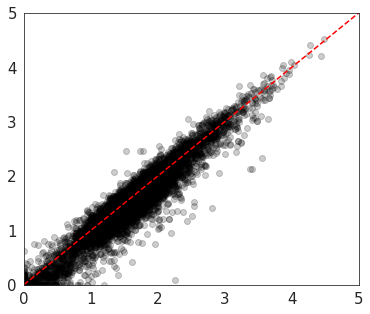

In [30]:
plt.figure(figsize = (6,5))
plt.plot(np.log10(RNAseq_RPKM.OAY1+1), np.log10(RNAseq_RPKM.gal+1),'o',color='k',alpha=0.2)
plt.plot([0,5],[0,5],'--',color = 'r')
plt.xlim([0,5])
plt.ylim([0,5])
print(stats.pearsonr(np.log10(RNAseq_RPKM.OAY1+1), np.log10(RNAseq_RPKM.gal+1)))

### Fig. 4 - supplemental figure 1B

In [31]:
PKA = ['YJL164C','YDR001C','YMR037C','YIR019C']
RNAseq_RPKM[RNAseq_RPKM.name.isin(PKA)] #PKA signaling not changed

,name,start,end,strand,fullstart,fullend,chr,gal,gal2,aF,aF2,OAY1,OAY2,gly,real_start,real_end,geneL,fold
951,YDR001C,452475,450219,-1,1812497,1810241,chrIV,74.642023,102.517749,204.418977,160.113127,92.922573,95.195823,158.126943,1810241,1812497,2256,1.050037
3063,YIR019C,393675,389571,-1,5786248,5782144,chrIX,7.360435,4.132371,7.669026,5.573777,4.978619,5.953666,24.949165,5782144,5786248,4104,0.842091
3142,YJL164C,111159,109965,-1,5943620,5942426,chrX,33.552949,58.840978,34.045285,25.233112,43.033073,36.970411,110.666285,5942426,5943620,1194,1.068440
4569,YMR037C,346517,344402,-1,8669722,8667607,chrXIII,53.667620,42.215349,35.427322,28.829785,25.720100,29.812996,31.772252,8667607,8669722,2115,0.821093


In [32]:
HOG = ['YLR113W','YDL022W','YOL151W','YLR109W','YDL168W','YPL091W','YML131W']
RNAseq_RPKM[RNAseq_RPKM.name.isin(HOG)] #HOG1/osmolarity not activated

,name,start,end,strand,fullstart,fullend,chr,gal,gal2,aF,aF2,OAY1,OAY2,gly,real_start,real_end,geneL,fold
790,YDL168W,159603,160764,1,1519625,1520786,chrIV,93.964826,89.710921,133.770508,100.926130,232.739726,195.569237,97.762990,1519625,1520786,1161,1.197804
928,YDL022W,411824,413000,1,1771846,1773022,chrIV,423.276754,807.831872,519.895443,499.065480,201.514680,202.896830,731.627256,1771846,1773022,1176,0.877764
3994,YLR109W,368780,369311,1,7613808,7614339,chrXII,395.408579,867.629918,318.958457,387.012684,846.265755,1021.738395,523.762758,7613808,7614339,531,1.126966
3998,YLR113W,371619,372927,1,7616647,7617955,chrXII,152.210857,151.105785,127.321756,98.354081,135.674114,142.919372,172.670978,7616647,7617955,1308,0.977301
4382,YML131W,10197,11295,1,8333402,8334500,chrXIII,62.463348,97.232973,159.415397,105.154138,244.642881,230.508972,94.707433,8333402,8334500,1098,1.326088
5321,YOL151W,43693,44722,1,10075662,10076691,chrXV,82.231402,101.262579,65.338607,58.136641,163.961146,149.231986,44.654750,10075662,10076691,1029,1.154714
6075,YPL091W,375501,376953,1,11498761,11500213,chrXVI,85.567682,92.850914,96.547870,72.544552,113.707827,109.239174,130.407560,11498761,11500213,1452,1.063095


In [33]:
HSF = ['YGL073W','YGR142W','YHR053C','YBL075C']
RNAseq_RPKM[RNAseq_RPKM.name.isin(HSF)] #Hsf1/heat shock not activated

,name,start,end,strand,fullstart,fullend,chr,gal,gal2,aF,aF2,OAY1,OAY2,gly,real_start,real_end,geneL,fold
137,YBL075C,86448,84498,-1,316666,314716,chrII,12.318079,11.901020,46.819955,31.736904,29.187912,30.323853,41.251088,314716,316666,1950,1.316060
2167,YGL073W,368752,371254,1,4107742,4110244,chrVII,18.158723,15.436914,26.145138,16.309886,19.231777,18.069475,26.265345,4107742,4110244,2502,1.018456
2394,YGR142W,772453,773686,1,4511443,4512676,chrVII,25.692360,32.081864,144.585469,92.205947,51.765719,66.704391,64.402575,4511443,4512676,1233,1.207493
2676,YHR053C,212720,212534,-1,5042650,5042464,chrVIII,375.872023,402.268979,412.497157,373.499427,1207.357504,1183.906570,779.669833,5042464,5042650,186,1.196414


In [34]:
YAP = ['YML007W','YJL101C','YGR209C','YNL102W']
RNAseq_RPKM[RNAseq_RPKM.name.isin(YAP)] #Yap1/oxidative stress/DNA damage not upregulated

,name,start,end,strand,fullstart,fullend,chr,gal,gal2,aF,aF2,OAY1,OAY2,gly,real_start,real_end,geneL,fold
2474,YGR209C,913227,912912,-1,4652217,4651902,chrVII,513.498957,810.791312,522.522333,471.675069,1197.345575,1100.847473,644.584943,4651902,4652217,315,1.135428
3209,YJL101C,236356,234319,-1,6068817,6066780,chrX,41.462426,62.068755,66.586593,48.177416,61.235330,69.578826,48.995849,6066780,6068817,2037,1.101985
4514,YML007W,253847,255800,1,8577052,8579005,chrXIII,46.971002,43.584826,67.566270,46.738502,57.194556,57.824170,59.876088,8577052,8579005,1953,1.049914
5111,YNL102W,430086,434493,1,9677722,9682129,chrXIV,10.898891,6.212528,5.002814,2.976604,9.011546,9.818505,5.799854,9677722,9682129,4407,0.930260


In [35]:
HAC = ['YFL031W','YJL034W']
RNAseq_RPKM[RNAseq_RPKM.name.isin(HAC)] #Hac1/UPR not upregulated

,name,start,end,strand,fullstart,fullend,chr,gal,gal2,aF,aF2,OAY1,OAY2,gly,real_start,real_end,geneL,fold
1865,YFL031W,75178,76147,1,3544007,3544976,chrVI,1052.532734,954.550057,1002.936996,923.908664,2583.103967,2953.877065,1483.239128,3544007,3544976,969,1.128914
3283,YJL034W,381326,383375,1,6213787,6215836,chrX,422.188451,342.077353,340.167298,261.090797,411.007090,404.906462,407.120707,6213787,6215836,2049,0.995572


In [36]:
DNAdam = ['YLR176C','YJL026W','YMR199W','YDL020C','YOL028C','YNL068C','YOR372C']
RNAseq_RPKM[RNAseq_RPKM.name.isin(DNAdam)] #various DNA damage responses, these genes will be up in response to any DNA damage

,name,start,end,strand,fullstart,fullend,chr,gal,gal2,aF,aF2,OAY1,OAY2,gly,real_start,real_end,geneL,fold
930,YDL020C,416708,415112,-1,1776730,1775134,chrIV,34.959870,31.326159,80.281393,57.707804,81.053738,70.779550,39.278776,1775134,1776730,1596,1.230284
3291,YJL026W,392403,393603,1,6224864,6226064,chrX,491.270841,544.766298,491.593630,401.394399,432.018629,411.373794,581.129604,6224864,6226064,1200,0.979312
4083,YLR176C,510232,507796,-1,7755260,7752824,chrXII,9.873599,10.202582,13.769741,8.749120,7.950454,6.982371,15.638418,7752824,7755260,2436,0.918438
4748,YMR199W,662643,664284,1,8985848,8987489,chrXIII,81.444889,58.243762,9.177810,7.545741,57.854204,52.261884,31.964461,8985848,8987489,1641,0.923605
5146,YNL068C,498289,495700,-1,9745925,9743336,chrXIV,21.897789,13.111325,17.045993,12.250961,17.568531,18.696895,22.905575,9743336,9745925,2589,0.933066
5448,YOL028C,271370,270632,-1,10303339,10302601,chrXV,13.651494,9.006448,16.426230,12.329378,20.967642,21.553745,9.994702,10302601,10303339,738,1.150874
5857,YOR372C,1036471,1034806,-1,11068440,11066775,chrXV,32.125966,26.585351,26.938027,22.346283,25.553218,21.444096,37.479774,11066775,11068440,1665,0.936815


In [37]:
ssens = ['YBR093C','YBR020W','YMR303C','YDR481C','YLR081W','YCR010C','YER072W','YBR018C','YAR035W','YPL019C','YBR019C','YJL153C']
RNAseq_RPKM[RNAseq_RPKM.name.isin(ssens)] #supercoiling sensitivity via plos paper: DNA Topoisomerases Maintain Promoters in a State Competent for Transcriptional Activation in Saccharomyces cerevisiae

,name,start,end,strand,fullstart,fullend,chr,gal,gal2,aF,aF2,OAY1,OAY2,gly,real_start,real_end,geneL,fold
92,YAR035W,190192,192256,1,190192,192256,chrI,20.084467,26.798980,218.614603,109.809190,75.439689,82.591944,109.667153,190192,192256,2064,1.422486
237,YBR018C,275527,274426,-1,505745,504644,chrII,5169.602924,4695.557240,2310.701772,2864.393090,3892.928187,3666.674824,3712.386529,504644,505745,1101,0.966837
238,YBR019C,278352,276252,-1,508570,506470,chrII,3141.353332,3100.336158,1551.304900,1815.408307,1654.152935,1755.489902,2158.644799,506470,508570,2100,0.920390
239,YBR020W,279020,280607,1,509238,510825,chrII,7108.330015,8043.223822,3435.877983,5826.661510,3731.041850,3771.391175,5115.185363,509238,510825,1587,0.927338
321,YBR093C,430951,429547,-1,661169,659765,chrII,157.361609,141.287848,18.383954,9.500724,146.747169,146.936153,173.976352,659765,661169,1404,0.986302
611,YCR010C,133124,132272,-1,1176526,1175674,chrIII,3.726339,5.149656,6.440444,3.841948,9.185705,10.106897,50.059886,1175674,1176526,852,1.494372
1451,YDR481C,1420250,1418549,-1,2780272,2778571,chrIV,101.137066,145.700155,158.802283,111.995493,104.193188,107.720175,174.491796,2778571,2780272,1701,1.006373
1687,YER072W,302805,303195,1,3194760,3195150,chrV,866.262607,706.731360,384.621473,301.849167,726.686173,709.200071,634.689734,3194760,3195150,390,0.974063
3154,YJL153C,135933,134331,-1,5968394,5966792,chrX,10.898472,10.796643,37.589703,20.503074,34.063892,30.463327,13.658496,5966792,5968394,1602,1.436423
3964,YLR081W,290211,291936,1,7535239,7536964,chrXII,8040.760715,8979.080525,3071.708267,4219.894197,8365.211901,8165.732142,6462.322646,7535239,7536964,1725,1.004399


([<matplotlib.axis.XTick at 0x7f33ded7a0b8>,
 <a list of 7 Text xticklabel objects>)

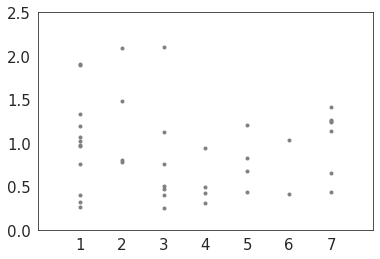

In [38]:
plt.plot(np.arange(12)*0+1,RNAseq_RPKM[RNAseq_RPKM.name.isin(ssens)].gal/RNAseq_RPKM[RNAseq_RPKM.name.isin(ssens)].OAY1,'.',c='grey',)
plt.plot(np.arange(4)*0+2,RNAseq_RPKM[RNAseq_RPKM.name.isin(PKA)].gal/RNAseq_RPKM[RNAseq_RPKM.name.isin(PKA)].OAY1,'.',c='grey',)
plt.plot(np.arange(7)*0+3,RNAseq_RPKM[RNAseq_RPKM.name.isin(HOG)].gal/RNAseq_RPKM[RNAseq_RPKM.name.isin(HOG)].OAY1,'.',c='grey',)
plt.plot(np.arange(4)*0+4,RNAseq_RPKM[RNAseq_RPKM.name.isin(HSF)].gal/RNAseq_RPKM[RNAseq_RPKM.name.isin(HSF)].OAY1,'.',c='grey',)
plt.plot(np.arange(4)*0+5,RNAseq_RPKM[RNAseq_RPKM.name.isin(YAP)].gal/RNAseq_RPKM[RNAseq_RPKM.name.isin(YAP)].OAY1,'.',c='grey',)
plt.plot(np.arange(2)*0+6,RNAseq_RPKM[RNAseq_RPKM.name.isin(HAC)].gal/RNAseq_RPKM[RNAseq_RPKM.name.isin(HAC)].OAY1,'.',c='grey',)
plt.plot(np.arange(7)*0+7,RNAseq_RPKM[RNAseq_RPKM.name.isin(DNAdam)].gal/RNAseq_RPKM[RNAseq_RPKM.name.isin(DNAdam)].OAY1,'.',c='grey',)
plt.ylim([0,2.5])
plt.xlim(0,8)
plt.xticks([1,2,3,4,5,6,7],[1,2,3,4,5,6,7])

### Fig. 4 - supplemental figure 1C

downloading GSM5001901_D20-5954_all_nodup.txt.gz from GEO
unzipping GSM5001901_D20-5954_all_nodup.txt.gz


/home/msguo/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


downloading GSM4628318_D19_5482_all.txt.gz from GEO
unzipping GSM4628318_D19_5482_all.txt.gz


(0, 0.6)

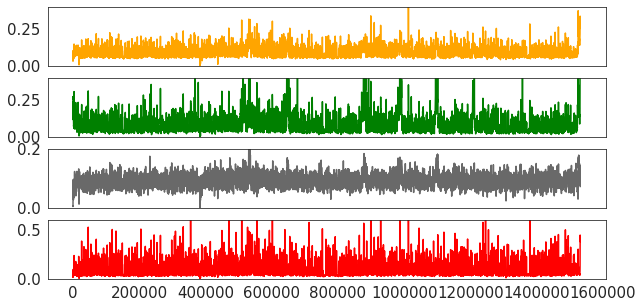

In [39]:
GapR_raffaF = loadraffaFChIP()
GapR_gly = loadglyChIP()

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,5),sharex=True)
start=1
end=len(GapR_raff[GapR_raff.chr=='chrIV'].val_norm)
axes[0].plot(np.arange(start, end),GapR_raff[GapR_raff.chr=='chrIV'].smooth[start:end], 'orange')
axes[0].set_ylim([0,0.4])
axes[1].plot(np.arange(start, end),GapR_raffaF[GapR_raffaF.chr=='chrIV'].smooth[start:end], 'green')
axes[1].set_ylim([0,0.4])
axes[2].plot(np.arange(start, end),GapR_raffneg[GapR_raffneg.chr=='chrIV'].smooth[start:end], 'dimgrey')
axes[2].set_ylim([0,0.2])
axes[3].plot(np.arange(start, end),GapR_gly[GapR_gly.chr=='chrIV'].smooth[start:end], 'red')
axes[3].set_ylim([0,0.6])

### Fig. 4 - supplemental figure 1D

In [40]:
GapR_raff2 = loadraff2ChIP()

rDNA = GapR_raff[(GapR_raff.chr=='chrXII') & (GapR_raff.pos > 448314) & (GapR_raff.pos < 493883)].index
rep1 = GapR_raff.drop(index=rDNA) #drop rDNA loci from chrXII
rep2 = GapR_raff2.drop(index=rDNA) #drop rDNA loci from chrXII
rep1['cumsums'] = rep1.val_norm.cumsum()
rep2['cumsums'] = rep2.val_norm.cumsum()

#bin data
N = 100
avgapR_rep1 = []
avgapR_rep2 = []
for x in np.arange(0,len(rep1),N):
    try:
        avgapR_rep1.append((rep1.iloc[x+N].cumsums-rep1.iloc[x].cumsums)/N)
        avgapR_rep2.append((rep2.iloc[x+N].cumsums-rep2.iloc[x].cumsums)/N)
    except:
        avgapR_rep1.append((rep1.iloc[len(rep1)-1].cumsums-rep1.iloc[x].cumsums)/N)
        avgapR_rep2.append((rep2.iloc[len(rep1)-1].cumsums-rep2.iloc[x].cumsums)/N)

%matplotlib auto
plt.figure(figsize=(6,5))
plt.scatter(avgapR_rep1,avgapR_rep2, marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.plot([0,1.35],[0,1.35],'--',c='red')
plt.xlim([0,0.9])
plt.ylim([0,0.9])
plt.xticks([0,0.5,1.0],size = 15)
plt.yticks([0,0.5,1.0],size = 15)
plt.savefig('Fig4_supp1D.png')
print(stats.pearsonr(avgapR_rep1,avgapR_rep2))
%matplotlib inline

downloading GSM5001900_D20-5953_all_nodup.txt.gz from GEO
unzipping GSM5001900_D20-5953_all_nodup.txt.gz


/home/msguo/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Using matplotlib backend: agg
(0.9719842714138541, 0.0)


### Fig. 4 - supplemental figure 1E

In [41]:
chromosomes_pl = {}
for key in iter(yeastgenome.keys()):
    chrX = pd.DataFrame(sliding_100[key], columns = ['value'])
    chrX.insert(0,'pos',chrX.index.values)
    chrX.insert(0,'chr',key)
    chromosomes_pl[key] = chrX
sliding_100_merged = chromosomes_pl['chrI'].copy()

for i in ['II','III','IV','V','VI','VII','VIII','IX','X','XI','XII','XIII','XIV','XV','XVI']:
    sliding_100_merged = sliding_100_merged.append(chromosomes_pl['chr'+i].copy())
sliding_100_merged.reset_index(drop=True, inplace=True)

sliding_100_merged['val_norm'] = GapR_raff.val_norm
rDNA = sliding_100_merged[(sliding_100_merged.chr=='chrXII') & (sliding_100_merged.pos > 448314) & (sliding_100_merged.pos < 493883)].index
sliding_100_merged.drop(index=rDNA, inplace=True) #drop rDNA loci from chrXII

avgapR = []
for i in range(10,90):
    avgapR.append(np.median(sliding_100_merged.val_norm.loc[sliding_100_merged.index[(sliding_100_merged.value >i) & (sliding_100_merged.value <=i+1)]].values))

%matplotlib auto
plt.figure(figsize=(6,5))
plt.scatter(sliding_100_merged.value,sliding_100_merged.val_norm, marker = 'o', s = 1, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.scatter(range(10,90),avgapR,c='red',marker = 'o')
plt.xlim([1,100])
print(stats.pearsonr(sliding_100_merged.value[126:-126],sliding_100_merged.val_norm[126:-126]))
plt.savefig('./yeast_highATcontent100_scatter.png')
%matplotlib inline

/home/msguo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/msguo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/msguo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/msguo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/msguo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/msguo/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/msguo/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:

Using matplotlib backend: agg
(0.12044422326530729, 0.0)


In [42]:
out_high = enrichedRegions(GapR_raff.smooth,0.376) #top 35 seqs
print(len(out_high))
seq_high = getSequence(out_high, GapR_raff,genomefasta, 'chip_yeast_high.test')
outu_high = unenrichedRegions(GapR_raff.smooth,0.055) #bottom 12%
print(len(outu_high))
sequ_high = getuSequence(outu_high, GapR_raff, genomefasta, 'chip_yeast_high_unbound.test')

37
1243


### Fig. 4 - supplemental figure 1F

In [43]:
GapR_gly = loadglyChIP()
GapR_glyneg = loadglynegChIP()
RNAseq_gly = loadyeastGlyRNAseqData()

downloading GSM4628318_D19_5482_all.txt.gz from GEO
unzipping GSM4628318_D19_5482_all.txt.gz


/home/msguo/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


downloading GSM4628316_D19_5480_all.txt.gz from GEO
unzipping GSM4628316_D19_5480_all.txt.gz
downloading GSM5001911_D20-3448_plus_all.txt.gz from GEO
unzipping GSM5001911_D20-3448_plus_all.txt.gz
downloading GSM5001911_D20-3448_minus_all.txt.gz from GEO
unzipping GSM5001911_D20-3448_minus_all.txt.gz


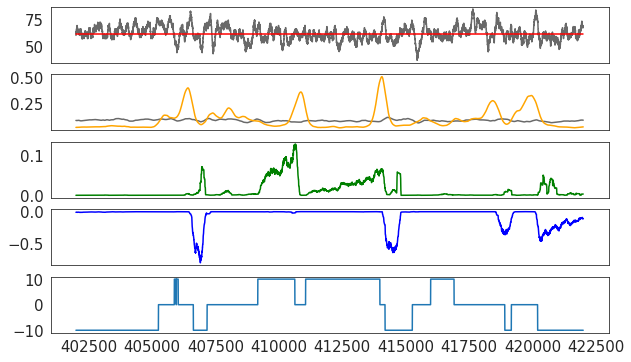

In [44]:
chrom = 'chrII'
start = 402000
end = 422000
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,6), sharey=False)
axes[0].plot(np.arange(start, end),sliding_100[chrom][start:end],'dimgrey')
axes[0].plot([start, end],[np.mean(sliding_100[chrom]),np.mean(sliding_100[chrom])], 'red')
axes[1].plot(np.arange(start, end),GapR_glyneg[GapR_glyneg.chr==chrom].smooth[start:end], 'dimgrey')
axes[1].plot(np.arange(start, end),GapR_gly[GapR_gly.chr==chrom].smooth[start:end], 'orange')

axes[2].plot(np.arange(start, end),(RNAseq_gly[RNAseq_gly.chr==chrom].fwd[start:end]),'green')
axes[3].plot(np.arange(start, end),-(RNAseq_gly[RNAseq_gly.chr==chrom].rev[start:end]),'blue')

axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[2].get_xaxis().set_visible(False)
axes[3].get_xaxis().set_visible(False)

axes[4].plot(np.arange(start, end), yeastgenome_gene_representation[chrom][0,start:end])

### Fig. 4 - supplemental figure 1G

In [45]:
top5pct = enrichedRegions(chip_fold.fold_nolog,1.65722) #top 5 pct of positions len(chip_fold[chip_fold.fold_nolog > 2.38255])/len(chip_fold)

chip_diff = chip_fold.fold_nolog

out = []
regions = top5pct
m = np.mean(chip_diff)
s = np.std(chip_diff)
for i in range(len(regions)):
    z = regions[i]
    c = chip_diff.loc[z[0]-15000:z[1]+15000]
    c_diff = c[c>(m+1/3*s)] #this is mean + 1/3 std
    j = z[1]
    while j < z[1]+15000:
        try:
            c_diff[j+1]
            j +=1
        except:
            end = j
            j = z[1]+15000
    j = z[0]
    while j > z[0]-15000:
        try:
            c_diff[j-1]
            j -=1
        except:
            start = j
            j = z[0]-15000
    if start > end:
        print('problem!')
    out.append(tuple([start,end]))
#merge GapR ChIPs
regions = sorted(list(set(out)))

out = []
i = 1
z = regions[0]
start = z[0]
end = z[1]
while i < len(regions):
    if regions[i][0] <= regions[i-1][1] + 150: #merge within 150 bp
        end = regions[i][1]
        i += 1
    else:
        out.append([start,end])
        i += 1
        z = regions[i-1]
        start = z[0]
        end = z[1]
out.append([start,end])
GapR_peaks = out

#check if any GapR_peaks are close to chr ends, exclude them
lengths = []
for i in la.items():
    lengths.append(i[1])
    
GapR_checked = []
for i in GapR_peaks:
    start = np.min(i)
    end = np.max(i)
    append = True
    if start - 1000 <= 0:
        append=False
    else:
        for j in lengths:
            if abs(start - j) <= 1000:
                append=False
            if abs(end - j) <= 1000:
                append=False
                print(i)
    if append == True:
        GapR_checked.append(i)        

[1039506, 1042449]
[1042700, 1044341]
[1357880, 1359064]
[1359513, 1360775]
[6577926, 6578748]
[10031233, 10032568]


[2884781, 2893251] 8470 >8000
[3463758, 3473945] 10187 >8000
[4822732, 4834537] 11805 >8000
[7726618, 7735220] 8602 >8000
[8309250, 8329487] 20237 >8000
[9246404, 9256242] 9838 >8000
[11114925, 11131217] 16292 >8000
931.9100418410042 744.5 899.5714235632599


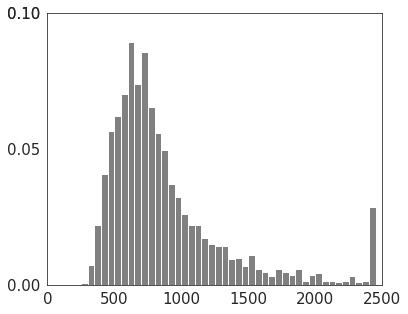

In [46]:
#calculate lengths for each of the GapR peaks:
gapR_length = []
for i in GapR_checked:
    m = i[1]-i[0] 
    gapR_length.append(i[1]-i[0])
    if i[1]-i[0] < 200:
        print(i, i[1]-i[0], '<200')
    if i[1]-i[0] > 8000:
        print(i, i[1]-i[0], '>8000')

plt.figure(figsize=[6,5])
bins = np.arange(0,2500,50)

h = np.histogram(np.clip(gapR_length,bins[0],bins[-1]), bins)

plt.bar(h[1][:-1], h[0]/float(len(gapR_length)), np.diff(h[1]),color='grey',alpha=1, align='edge')
plt.xlim([0,2500])
plt.xticks([0,500,1000,1500,2000,2500],size = 15)
plt.yticks([0,0.05,0.1,0.1],size = 15)

print(np.mean(gapR_length), np.median(gapR_length), np.std(gapR_length))

### Fig. 4 - supplemental figure 1H

In [47]:
#Data from Fig. 4 - supplemental figure 1H was generated as with Fig. 4C except with glycerol data:
chip_fold_gly = loadChIPFold(GapR_gly, GapR_glyneg)

### Fig. 4 - supplemental 1I

In [48]:
#Data from Fig. 4 - supplemental figure 1I was generated as with Fig. 4E except with glycerol data

### Fig. 4 - supplemental 1J

In [49]:
#Data from Fig. 4 - supplemental figure 1J was generated as with Fig. 4F except with glycerol data

### Fig. 4 - supplemental 1K

In [50]:
RNAseq_RPKM['real_start']=RNAseq_RPKM[['fullstart','fullend']].min(axis=1)
RNAseq_RPKM['real_end']=RNAseq_RPKM[['fullstart','fullend']].max(axis=1)
RNAseq_RPKM['geneL'] = RNAseq_RPKM.apply(lambda r:r['real_end']-r['real_start'],axis=1)
high_exp = RNAseq_RPKM[['name','strand','chr','real_start','real_end','geneL','gal']]
high_exp_final = high_exp

df_regions = pd.concat([high_exp_final,high_exp_final.shift(-1)],axis=1,keys=['left','right'],names=['gene'])
df_regions.columns = ['{}_{}'.format(x,y) for x,y in df_regions.columns]
df_regions = df_regions.dropna(subset=['right_real_start'])
df_regions=df_regions.loc[df_regions['left_chr']==df_regions['right_chr']]
df_regions.loc[df_regions['left_strand']==df_regions['right_strand'],'intergenic_type']='same'
df_regions.loc[(df_regions['left_strand']==1) & (df_regions['right_strand']==-1),'intergenic_type']='conv'
df_regions.loc[(df_regions['left_strand']==-1) & (df_regions['right_strand']==1),'intergenic_type']='div'

In [51]:
df_regions['intergenic_mean_gapR']=df_regions.apply(lambda r:chip_fold.fold_nolog.loc[r['left_real_end']:r['right_real_start']].mean(),axis=1)
df_regions['intergenic_length']=df_regions.apply(lambda r:r['right_real_start']-r['left_real_end'],axis=1)
df_final = df_regions[df_regions.intergenic_length >50] #filter out things that are within X bases
df_ts = df_final[(df_final.intergenic_type=='same') & (df_final.left_strand == 1)].copy()
df_bs=df_final[(df_final.intergenic_type=='same') & (df_final.left_strand == -1)].copy()

(0.2774837974544951, 1.160022269784612e-53)
(0.0043938339307210104, 0.8107996534765501)


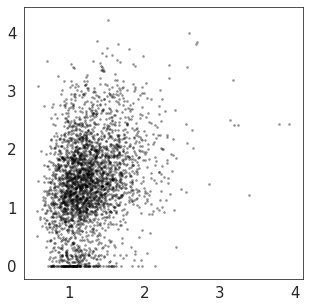

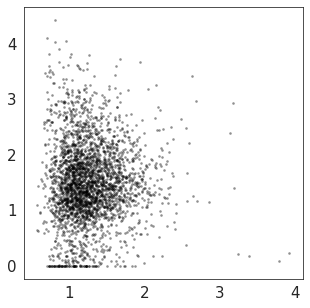

In [52]:
#plot 5pr_corr of all genes
plt.figure(figsize=(5,5))
plt.scatter(df_ts.intergenic_mean_gapR,np.log10(df_ts.left_gal+1),marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.scatter(df_bs.intergenic_mean_gapR,np.log10(df_bs.right_gal+1),marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
print(stats.pearsonr(df_ts.intergenic_mean_gapR.append(df_bs.intergenic_mean_gapR),np.log10(df_ts.left_gal.append(df_bs.right_gal)+1)))

#plot 3pr_corr of all genes
plt.figure(figsize=(5,5))
plt.scatter(df_ts.intergenic_mean_gapR,np.log10(df_ts.right_gal+1),marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.scatter(df_bs.intergenic_mean_gapR,np.log10(df_bs.left_gal+1),marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
print(stats.pearsonr(df_ts.intergenic_mean_gapR.append(df_bs.intergenic_mean_gapR),np.log10(df_ts.right_gal.append(df_bs.left_gal)+1)))

(0.2854823349159706, 4.539000447500656e-24)
(0.08471458002889778, 0.003225453100314178)


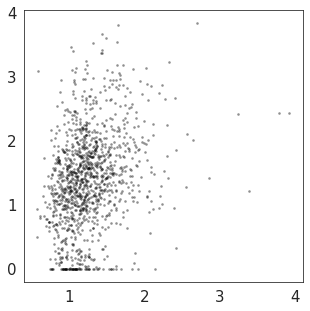

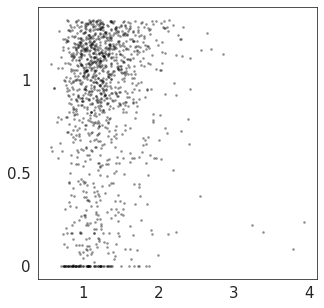

In [53]:
#repeat analysis for poorly expressed genes only
df_poor_ts = df_final[(df_final.right_gal < 20) & (df_final.intergenic_type=='same') & (df_final.left_strand == 1)].copy()
df_poor_bs=df_final[(df_final.left_gal < 20) & (df_final.intergenic_type=='same') & (df_final.left_strand == -1)].copy()

#plot 5pr_corr of poorly expressed genes
plt.figure(figsize=(5,5))
plt.scatter(df_poor_ts.intergenic_mean_gapR,np.log10(df_poor_ts.left_gal+1),marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.scatter(df_poor_bs.intergenic_mean_gapR,np.log10(df_poor_bs.right_gal+1),marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
print(stats.pearsonr(df_poor_ts.intergenic_mean_gapR.append(df_poor_bs.intergenic_mean_gapR),np.log10(df_poor_ts.left_gal.append(df_poor_bs.right_gal)+1)))
plt.yticks([0,1,2,3,4],[0,1,2,3,4])

#plot 3pr_corr of poorly expressed genes
plt.figure(figsize=(5,5))
plt.scatter(df_poor_ts.intergenic_mean_gapR,np.log10(df_poor_ts.right_gal+1),marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.scatter(df_poor_bs.intergenic_mean_gapR,np.log10(df_poor_bs.left_gal+1),marker = 'o', s = 3, c = 'black', edgecolors = 'face', alpha = 0.3)
plt.yticks([0,0.5,1],[0,0.5,1])
print(stats.pearsonr(df_poor_ts.intergenic_mean_gapR.append(df_poor_bs.intergenic_mean_gapR),np.log10(df_poor_ts.right_gal.append(df_poor_bs.left_gal)+1)))